# HÜK250

Clip HÜK250 to catchment and extract variables.  
As HÜK250 is in german language, we translate the variable names to english in the extracted output.

**Variables**:
- KF (Durchlässigkeit) -> `Permeability`
- CH (Grundwasserleiter/-geringleiter) -> `Aquifer media type`
- HA (Hohlraumart) -> `Cavity type`
- VF (Verfestigung) -> `Consolidation`
- GA (Gesteinsart) -> `Rock type`
- GC (Geochemischer Gesteinstyp) -> `Geochemical rock type`

In general, the notebook is used to calculate the percentage of coverage of the entire catchment area of the different classes of the variables.

In [1]:
import geopandas as gpd
import pandas as pd
import contextily as ctx
import matplotlib.pyplot as plt
from numpy.testing import assert_almost_equal
import os

## Functions for plotting, checking and extraction

### Plotting function

In [2]:
def plot_huek(huek_clipped: gpd.GeoDataFrame, catchment: gpd.GeoDataFrame, column: str, show_plot: bool = True) -> plt.Figure:
    """
    Plot the clipped huek250 with the given column.

    Parameters
    ----------
    huek_clipped : gpd.GeoDataFrame
        The clipped huek250 data.
    catchment : gpd.GeoDataFrame
        The catchment boundary.
    column : str
        The column to plot.
    show_plot : bool, optional
        Whether to show the plot or not, by default True.

    Returns
    -------
    plt.Figure
        The plot figure.
    
    """
    fig, ax = plt.subplots(figsize=(16, 7))

    # plot huek
    huek_clipped.plot(column=column, ax=ax, legend=True)

    # legend next to plot
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((1.5, 1))

    # plot ezg boundary
    catchment.boundary.plot(ax=ax, color="black", linewidth=3)

    # Increase x and y limits
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_xlim(xmin - 0.2*(xmax-xmin), xmax + 0.2*(xmax-xmin))
    ax.set_ylim(ymin - 0.2*(ymax-ymin), ymax + 0.2*(ymax-ymin))
    
    # add basemap
    #ctx.add_basemap(ax, crs=huek_clipped.crs, source=ctx.providers.OpenTopoMap)

    # add x and y labels
    ax.set_xlabel("x coordinate [m]")
    ax.set_ylabel("y coordinate [m]")

    # add title
    ax.set_title(f"{column} clipped to catchment {catchment['LABEL'].values[0]}")

    if show_plot:
        plt.show()
    else:
        plt.close(fig)

    return fig

### Function to check extracted data

In [3]:
def check_extracted_values(df: pd.DataFrame, category: str):
    # check that category sums to 1
    sum_category = df[[col for col in df.columns if col.startswith(category)]].sum(axis=1)[0]
    
    # assert that the sum is approximately 1
    assert_almost_equal(sum_category, 100, decimal=1, err_msg=f"Sum of {category} categories is not 100 but {sum_category}")

## Permeability / Durchlässigkeit (KF)

Permeability is given as classes (low, low-medium, medium, ...) -> 11 classes in total + highly variable and waterbody.   

Classes, rename to english:
- sehr hoch (>1E-2) --> kf_very_high_perc
- hoch (>1E-3 - 1E-2) --> kf_high_perc
- mittel (>1E-4 - 1E-3) --> kf_medium_perc
- mäßig (>1E-5 - 1E-4) --> kf_moderate_perc
- gering (>1E-7 - 1E-5) --> kf_low_perc
- sehr gering (>1E-9 - 1E-7) --> kf_very_low_perc
- äußerst gering (<1E-9) --> kf_extremely_low_perc
- sehr hoch bis hoch (>1E-3) --> kf_very_high_to_high_perc
- mittel bis mäßig (>1E-5 - 1E-3) --> kf_medium_to_moderate_perc
- gering bis äußerst gering (<1E-5) --> kf_low_to_extremely_low_perc
- stark variabel --> kf_highly_variable_perc
- mäßig bis gering (>1E-6 - 1E-4) --> kf_moderate_to_low_perc
- Gewässer --> kf_water_body_perc
- keine Angaben --> kf_no_data_perc


In [4]:
def extract_kf_from_huek(huek: gpd.GeoDataFrame, catchment: gpd.GeoDataFrame) -> tuple[pd.DataFrame, plt.Figure]:
    """
    Extract the huek250 kf data for the given catchment.

    Parameters
    ----------
    huek : gpd.GeoDataFrame
        The huek250 data.
    catchment : gpd.GeoDataFrame
        The catchment GeoDataFrame, same projection as huek.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with the extracted data.
    fig : plt.Figure
        Figure with the plot of the HUEK data clipped to catchment geometry.
        
    """
    # clip huek to catchment boundary
    clipped = huek.clip(catchment)

    # plot clipped huek
    fig = plot_huek(clipped, catchment, "kf_bez", show_plot=True)

    # initialize pandas DataFrame to store results
    df = pd.DataFrame(columns=["camels_id"])
    df["camels_id"] = [catchment["LABEL"].values[0]]

    # calculate area percentage for each category
    df["kf_very_high_perc"] = (clipped[clipped["kf_bez"] == "sehr hoch (>1E-2)"].area.sum() / clipped.area.sum()) * 100
    df["kf_high_perc"] = (clipped[clipped["kf_bez"] == "hoch (>1E-3 - 1E-2)"].area.sum() / clipped.area.sum()) * 100
    df["kf_medium_perc"] = (clipped[clipped["kf_bez"] == "mittel (>1E-4 - 1E-3)"].area.sum() / clipped.area.sum()) * 100
    df["kf_moderate_perc"] = (clipped[clipped["kf_bez"] == "mäßig (>1E-5 - 1E-4)"].area.sum() / clipped.area.sum()) * 100
    df["kf_low_perc"] = (clipped[clipped["kf_bez"] == "gering (>1E-7 - 1E-5)"].area.sum() / clipped.area.sum()) * 100
    df["kf_very_low_perc"] = (clipped[clipped["kf_bez"] == "sehr gering (>1E-9 - 1E-7)"].area.sum() / clipped.area.sum()) * 100
    df["kf_extremely_low_perc"] = (clipped[clipped["kf_bez"] == "äußerst gering (<1E-9)"].area.sum() / clipped.area.sum()) * 100
    df["kf_very_high_to_high_perc"] = (clipped[clipped["kf_bez"] == "sehr hoch bis hoch (>1E-3)"].area.sum() / clipped.area.sum()) * 100
    df["kf_medium_to_moderate_perc"] = (clipped[clipped["kf_bez"] == "mittel bis mäßig (>1E-5 - 1E-3)"].area.sum() / clipped.area.sum()) * 100
    df["kf_low_to_extremely_low_perc"] = (clipped[clipped["kf_bez"] == "gering bis äußerst gering (<1E-5)"].area.sum() / clipped.area.sum()) * 100
    df["kf_highly_variable_perc"] = (clipped[clipped["kf_bez"] == "stark variabel"].area.sum() / clipped.area.sum()) * 100
    df["kf_moderate_to_low_perc"] = (clipped[clipped["kf_bez"] == "mäßig bis gering (>1E-6 - 1E-4)"].area.sum() / clipped.area.sum()) * 100
    df["kf_waterbody_perc"] = (clipped[clipped["kf_bez"] == "Gewässer"].area.sum() / clipped.area.sum()) * 100
    df["kf_no_data_perc"] = (clipped[clipped["kf_bez"] == "keine Angaben"].area.sum() / clipped.area.sum()) * 100

    # check if extracted categories sum to 1
    check_extracted_values(df, "kf")

    return df, fig
    

## Aquifer media type / Grundwasserleiter/-geringleiter (CH)

Classes, rename to englisch:
- perc_gw_leiter --> aquifer_perc
- perc_gw_geringleiter --> aquitard_perc
- perc_gw_mixed --> aquifer_aquitard_mixed_perc
- perc_gw_na -> aquifer_no_data_perc
- perc_gw_waterbody -> aquifer_waterbody_perc

In [5]:
def extract_ch_from_huek(huek: gpd.GeoDataFrame, catchment: gpd.GeoDataFrame) -> tuple[pd.DataFrame, plt.Figure]:
    """
    Extract the huek250 ch data for the given catchment.

    Parameters
    ----------
    huek : gpd.GeoDataFrame
        The huek250 data.
    catchment : gpd.GeoDataFrame
        The catchment GeoDataFrame, same projection as huek.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with the extracted data.
    fig : plt.Figure
        Figure with the plot of the HUEK data clipped to catchment geometry.
        
    """
    # clip huek to catchment boundary
    clipped = huek.clip(catchment)

    # plot clipped huek
    fig = plot_huek(clipped, catchment, "LChar_bez", show_plot=False)

    # initialize pandas DataFrame to store results
    df = pd.DataFrame(columns=["camels_id"])
    df["camels_id"] = [catchment["LABEL"].values[0]]

    # calculate area percentage for each category
    df["aquitard_perc"] = (clipped[clipped["LChar_bez"]=="Grundwasser-Geringleiter"].area.sum() / clipped.area.sum()) * 100
    df["aquifer_perc"] = (clipped[clipped["LChar_bez"]=="Grundwasser-Leiter"].area.sum() / clipped.area.sum()) * 100
    df["aquifer_aquitard_mixed_perc"] = (clipped[clipped["LChar_bez"]=="Grundwasser-Leiter/Geringleiter"].area.sum() / clipped.area.sum()) * 100
    df["aquifer_waterbody_perc"] = (clipped[clipped["LChar_bez"]=="Gewässer"].area.sum() / clipped.area.sum()) * 100
    df["aquifer_no_data_perc"] = (clipped[clipped["LChar_bez"]=="keine Angaben"].area.sum() / clipped.area.sum()) * 100

    # check if extracted categories sum to 1
    check_extracted_values(df, "aqui")

    return df, fig

## Cavity type / Hohlraumart (HA)

Classes, rename to english:
- Kluft --> cavity_fissure_perc
- Poren --> cavity_pores_perc
- Kluft/Karst --> cavity_fissure_karst_perc
- Kluft/Poren --> cavity_fissure_pores_perc
- Gewässer --> cavity_waterbody_perc
- keine Angaben --> cavity_no_data_perc

In [6]:
def extract_ha_from_huek(huek: gpd.GeoDataFrame, catchment: gpd.GeoDataFrame) -> tuple[pd.DataFrame, plt.Figure]:
    """
    Extract the huek250 ha data for the given catchment.

    Parameters
    ----------
    huek : gpd.GeoDataFrame
        The huek250 data.
    catchment : gpd.GeoDataFrame
        The catchment GeoDataFrame, same projection as huek.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with the extracted data.
    fig : plt.Figure
        Figure with the plot of the HUEK data clipped to catchment geometry.
        
    """
    # clip huek to catchment boundary
    clipped = huek.clip(catchment)

    # plot clipped huek
    fig = plot_huek(clipped, catchment, "HA_bez", show_plot=False)

    # initialize pandas DataFrame to store results
    df = pd.DataFrame(columns=["camels_id"])
    df["camels_id"] = [catchment["LABEL"].values[0]]

    # calculate area percentage for each category
    df["cavity_fissure_perc"] = (clipped[clipped["HA_bez"]=="Kluft"].area.sum() / clipped.area.sum()) * 100
    df["cavity_pores_perc"] = (clipped[clipped["HA_bez"]=="Poren"].area.sum() / clipped.area.sum()) * 100
    df["cavity_fissure_karst_perc"] = (clipped[clipped["HA_bez"]=="Kluft/Karst"].area.sum() / clipped.area.sum()) * 100
    df["cavity_fissure_pores_perc"] = (clipped[clipped["HA_bez"]=="Kluft/Poren"].area.sum() / clipped.area.sum()) * 100
    df["cavity_waterbody_perc"] = (clipped[clipped["HA_bez"]=="Gewässer"].area.sum() / clipped.area.sum()) * 100
    df["cavity_no_data_perc"] = (clipped[clipped["HA_bez"]=="keine Angaben"].area.sum() / clipped.area.sum()) * 100

    # check if extracted categories sum to 1
    check_extracted_values(df, "cavity")

    return df, fig

## Consolidation / Verfestigung (VF)

Classes, rename to english:
- Festgestein --> consolidation_solid_rock_perc
- Lockergestein --> consolidation_unconsolidated_rock_perc
- Gewässer --> consolidation_waterbody_perc
- keine Angaben --> consolidation_no_data_perc

In [7]:
def extract_vf_from_huek(huek: gpd.GeoDataFrame, catchment: gpd.GeoDataFrame) -> tuple[pd.DataFrame, plt.Figure]:
    """
    Extract the huek250 vf data for the given catchment.

    Parameters
    ----------
    huek : gpd.GeoDataFrame
        The huek250 data.
    catchment : gpd.GeoDataFrame
        The catchment GeoDataFrame, same projection as huek.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with the extracted data.
    fig : plt.Figure
        Figure with the plot of the HUEK data clipped to catchment geometry.
        
    """
    # clip huek to catchment boundary
    clipped = huek.clip(catchment)

    # plot clipped huek
    fig = plot_huek(clipped, catchment, "VF_bez", show_plot=False)

    # initialize pandas DataFrame to store results
    df = pd.DataFrame(columns=["camels_id"])
    df["camels_id"] = [catchment["LABEL"].values[0]]

    # calculate area percentage for each category
    df["consolidation_solid_rock_perc"] = (clipped[clipped["VF_bez"]=="Festgestein"].area.sum() / clipped.area.sum()) * 100
    df["consolidation_unconsolidated_rock_perc"] = (clipped[clipped["VF_bez"]=="Lockergestein"].area.sum() / clipped.area.sum()) * 100
    df["consolidation_waterbody_perc"] = (clipped[clipped["VF_bez"]=="Gewässer"].area.sum() / clipped.area.sum()) * 100
    df["consolidation_no_data_perc"] = (clipped[clipped["VF_bez"]=="keine Angaben"].area.sum() / clipped.area.sum()) * 100

    # check if extracted categories sum to 1
    check_extracted_values(df, "consolidation")

    return df, fig

## Rock type / Gesteinsart (GA)

Classes, rename to english:
- Sediment --> rocktype_sediment_perc
- Metamorphit --> rocktype_metamorphite_perc
- Magmatit --> rocktype_magmatit_perc
- Gewässer --> rocktype_waterbody_perc
- keine Angaben --> rocktype_no_data_perc

In [8]:
def extract_ga_from_huek(huek: gpd.GeoDataFrame, catchment: gpd.GeoDataFrame) -> tuple[pd.DataFrame, plt.Figure]:
    """
    Extract the huek250 ga data for the given catchment.

    Parameters
    ----------
    huek : gpd.GeoDataFrame
        The huek250 data.
    catchment : gpd.GeoDataFrame
        The catchment GeoDataFrame, same projection as huek.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with the extracted data.
    fig : plt.Figure
        Figure with the plot of the HUEK data clipped to catchment geometry.
        
    """
    # clip huek to catchment boundary
    clipped = huek.clip(catchment)

    # plot clipped huek
    fig = plot_huek(clipped, catchment, "GA_bez", show_plot=False)

    # initialize pandas DataFrame to store results
    df = pd.DataFrame(columns=["camels_id"])
    df["camels_id"] = [catchment["LABEL"].values[0]]

    # calculate area percentage for each category
    df["rocktype_sediment_perc"] = (clipped[clipped["GA_bez"]=="Sediment"].area.sum() / clipped.area.sum()) * 100
    df["rocktype_metamorphite_perc"] = (clipped[clipped["GA_bez"]=="Metamorphit"].area.sum() / clipped.area.sum()) * 100
    df["rocktype_magmatite_perc"] = (clipped[clipped["GA_bez"]=="Magmatit"].area.sum() / clipped.area.sum()) * 100
    df["rocktype_waterbody_perc"] = (clipped[clipped["GA_bez"]=="Gewässer"].area.sum() / clipped.area.sum()) * 100
    df["rocktype_no_data_perc"] = (clipped[clipped["GA_bez"]=="keine Angaben"].area.sum() / clipped.area.sum()) * 100

    # check if extracted categories sum to 1
    check_extracted_values(df, "rocktype")

    return df, fig

## Geochemical rock type / Geochemischer Gesteinstyp (GC)

Classes, rename to english:
- silikatisch --> geochemical_rocktype_silicate_perc
- silikatisch/karbonatisch --> geochemical_rocktype_silicate_carbonatic_perc
- karbonatisch --> geochemical_rocktype_carbonatic_perc
- sulfatisch --> geochemical_rocktype_sulfatic_perc
- silikatisch mit organischen Anteilen --> geochemical_rocktype_silicate_organic_components_perc
- durch Auffüllung anthropogen verändert --> geochemical_rocktype_anthropogenically_modified_through_filling_perc
- sulfatisch/halitisch --> geochemical_rocktype_sulfatic_halitic_perc
- halitisch --> geochemical_rocktype_halitic_perc
- Gewässer --> geochemical_rocktype_waterbody_perc
- keine Angaben --> geochemical_rocktype_no_data_perc

In [9]:
def extract_gc_from_huek(huek: gpd.GeoDataFrame, catchment: gpd.GeoDataFrame) -> tuple[pd.DataFrame, plt.Figure]:
    """
    Extract the huek250 ga data for the given catchment.

    Parameters
    ----------
    huek : gpd.GeoDataFrame
        The huek250 data.
    catchment : gpd.GeoDataFrame
        The catchment GeoDataFrame, same projection as huek.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with the extracted data.
    fig : plt.Figure
        Figure with the plot of the HUEK data clipped to catchment geometry.
        
    """
    # clip huek to catchment boundary
    clipped = huek.clip(catchment)

    # plot clipped huek
    fig = plot_huek(clipped, catchment, "GC_bez", show_plot=False)

    # initialize pandas DataFrame to store results
    df = pd.DataFrame(columns=["camels_id"])
    df["camels_id"] = [catchment["LABEL"].values[0]]

    # calculate area percentage for each category
    df["geochemical_rocktype_silicate_perc"] = (clipped[clipped["GC_bez"]=="silikatisch"].area.sum() / clipped.area.sum()) * 100
    df["geochemical_rocktype_silicate_carbonatic_perc"] = (clipped[clipped["GC_bez"]=="silikatisch/karbonatisch"].area.sum() / clipped.area.sum()) * 100
    df["geochemical_rocktype_carbonatic_perc"] = (clipped[clipped["GC_bez"]=="karbonatisch"].area.sum() / clipped.area.sum()) * 100
    df["geochemical_rocktype_sulfatic_perc"] = (clipped[clipped["GC_bez"]=="sulfatisch"].area.sum() / clipped.area.sum()) * 100
    df["geochemical_rocktype_silicate_organic_components_perc"] = (clipped[clipped["GC_bez"]=="silikatisch mit organischen Anteilen"].area.sum() / clipped.area.sum()) * 100
    df["geochemical_rocktype_anthropogenically_modified_through_filling_perc"] = (clipped[clipped["GC_bez"]=="durch Auffüllung anthropogen verändert"].area.sum() / clipped.area.sum()) * 100
    df["geochemical_rocktype_sulfatic_halitic_perc"] = (clipped[clipped["GC_bez"]=="sulfatisch/halitisch"].area.sum() / clipped.area.sum()) * 100
    df["geochemical_rocktype_halitic_perc"] = (clipped[clipped["GC_bez"]=="halitisch"].area.sum() / clipped.area.sum()) * 100
    df["geochemical_rocktype_waterbody_perc"] = (clipped[clipped["GC_bez"]=="Gewässer"].area.sum() / clipped.area.sum()) * 100
    df["geochemical_rocktype_no_data_perc"] = (clipped[clipped["GC_bez"]=="keine Angaben"].area.sum() / clipped.area.sum()) * 100

    # check if extracted categories sum to 1
    check_extracted_values(df, "geochemical_rocktype")

    return df, fig

## Extract

Extract all wanted categories from HUEK250 for all CAMELS-DE catchments and save results.

Processing CAMELS_ID 1


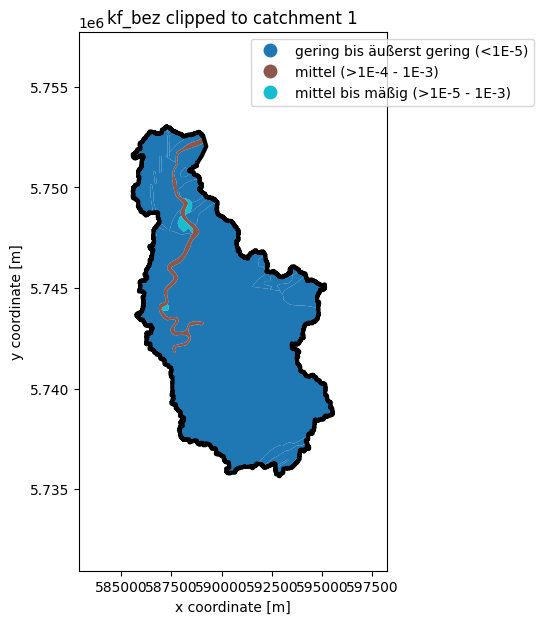

Processing CAMELS_ID 2


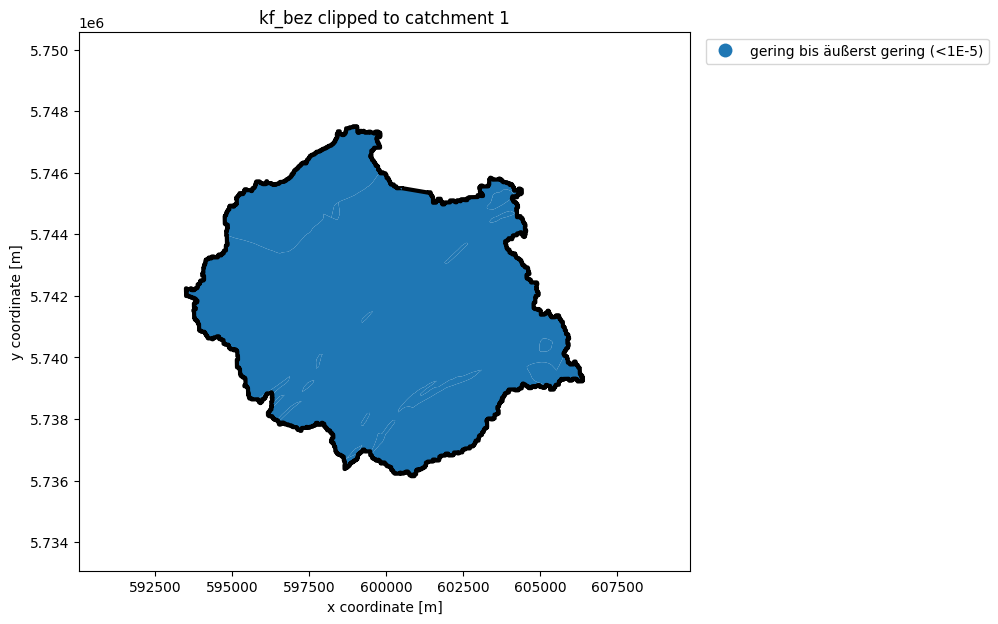

Processing CAMELS_ID 3


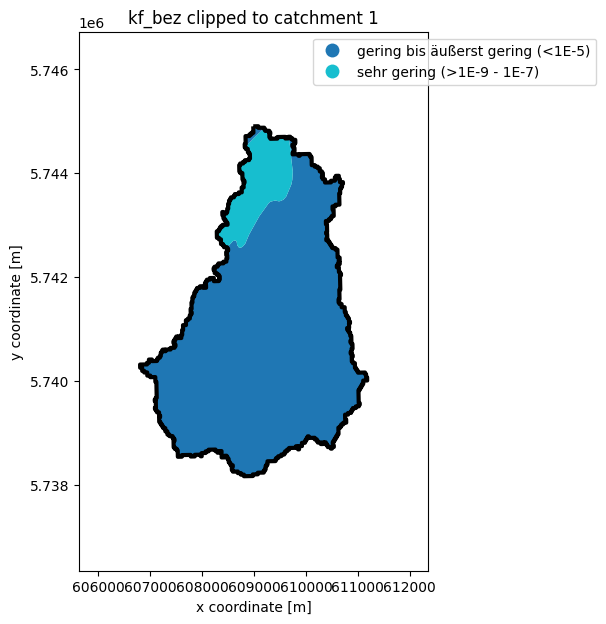

Processing CAMELS_ID 4


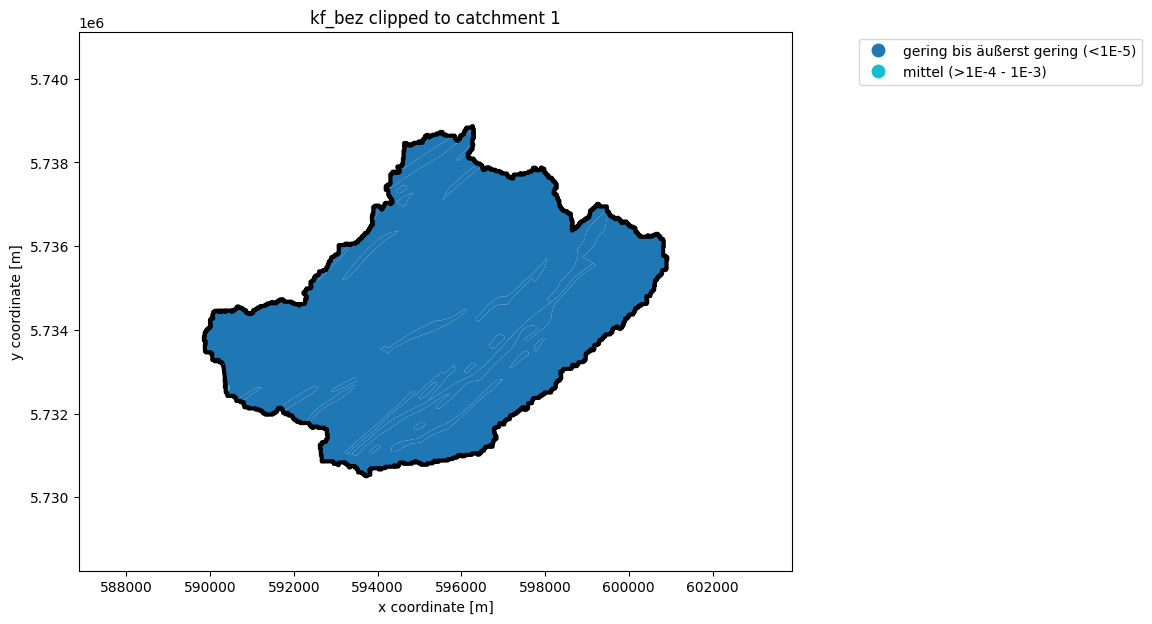

Processing CAMELS_ID 5


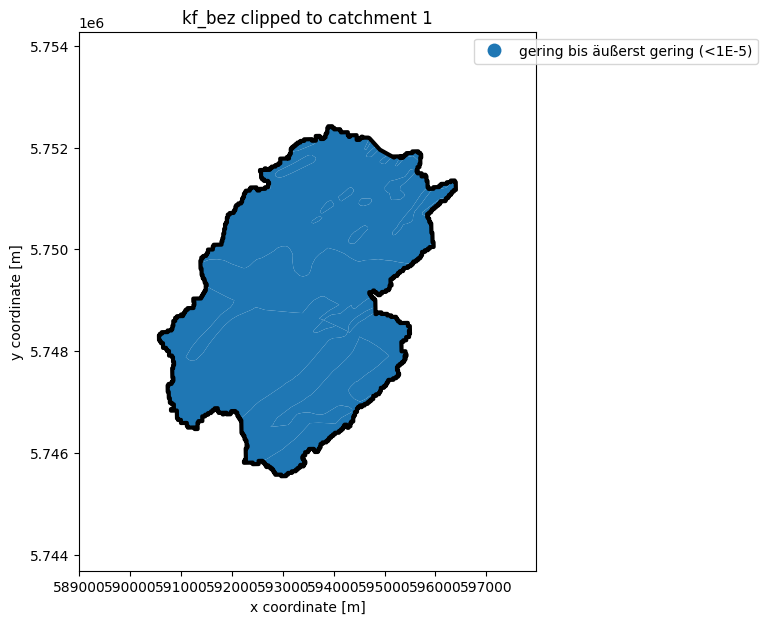

In [12]:
# read huek250
huek = gpd.read_file("../input_data/huek250/huek250_v103/shp/huek250__25832_v103_poly.shp")

# Define IDs and variables
CAMELS_IDS = [1, 2, 3, 4, 5]

CATCHMENT_PATH = "../../../catchments_harz"

# Mapping catchment IDs to shapefiles
id_mapping = {
    1: dict(shapefile = "innerste_reservoir_catchment.shp", catchment_id = 1),
    2: dict(shapefile = "oker_reservoir_catchment.shp", catchment_id = 2),
    3: dict(shapefile = "ecker_reservoir_catchment.shp", catchment_id = 3),
    4: dict(shapefile = "soese_reservoir_catchment.shp", catchment_id = 4),
    5: dict(shapefile = "grane_reservoir_catchment.shp", catchment_id = 5),
}

# loop over all camels ids
for camels_id in CAMELS_IDS:
    print(f"Processing CAMELS_ID {camels_id}")
    # initialize station
    catchment_info = id_mapping[camels_id]
    shapefile_path = os.path.join(CATCHMENT_PATH, catchment_info["shapefile"])
    catchment = gpd.read_file(shapefile_path)

    if catchment is None:
        continue
    
    # if camels_id was already processed, skip
    if all([os.path.exists(f"../output_data/{camels_id}/data/huek250_{cat}.csv") for cat in ["kf", "ch", "ha", "vf", "ga", "gc"]]):
        continue

    # reproject ezg to huek
    catchment = catchment.to_crs(huek.crs)

    # extract data
    try:
        df_kf, fig_kf = extract_kf_from_huek(huek, catchment)
        df_ch, fig_ch = extract_ch_from_huek(huek, catchment)
        df_ha, fig_ha = extract_ha_from_huek(huek, catchment)
        df_vf, fig_vf = extract_vf_from_huek(huek, catchment)
        df_ga, fig_ga = extract_ga_from_huek(huek, catchment)
        df_gc, fig_gc = extract_gc_from_huek(huek, catchment)
    except AssertionError as e:
        print(f"[{camels_id}] -- {e}")
        continue

    # create output directories
    os.makedirs(f"../output_data/{camels_id}", exist_ok=True)
    os.makedirs(f"../output_data/{camels_id}/data", exist_ok=True)
    os.makedirs(f"../output_data/{camels_id}/plots", exist_ok=True)

    # save extracted data
    df_kf.to_csv(f"../output_data/{camels_id}/data/huek250_kf.csv", index=False)
    df_ch.to_csv(f"../output_data/{camels_id}/data/huek250_ch.csv", index=False)
    df_ha.to_csv(f"../output_data/{camels_id}/data/huek250_ha.csv", index=False)
    df_vf.to_csv(f"../output_data/{camels_id}/data/huek250_vf.csv", index=False)
    df_ga.to_csv(f"../output_data/{camels_id}/data/huek250_ga.csv", index=False)
    df_gc.to_csv(f"../output_data/{camels_id}/data/huek250_gc.csv", index=False)

    # save figures
    fig_kf.savefig(f"../output_data/{camels_id}/plots/huek250_kf.png")
    fig_ch.savefig(f"../output_data/{camels_id}/plots/huek250_ch.png")
    fig_ha.savefig(f"../output_data/{camels_id}/plots/huek250_ha.png")
    fig_vf.savefig(f"../output_data/{camels_id}/plots/huek250_vf.png")
    fig_ga.savefig(f"../output_data/{camels_id}/plots/huek250_ga.png")
    fig_gc.savefig(f"../output_data/{camels_id}/plots/huek250_gc.png")
